In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Ennio Doorbell Data Pre-Processing

In [3]:
# Benign traffic

ed_benign = pd.read_csv('nbaiot/Ennio_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_ed_benign = ed_benign.copy(deep=True)

columns = list(df_ed_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_ed_benign = pd.DataFrame(df_ed_benign, columns = chosen_columns)

# Bashlite

ed_bashlite_combo = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_combo = ed_bashlite_combo.copy(deep=True)
df_ed_bashlite_combo = pd.DataFrame(df_ed_bashlite_combo, columns = chosen_columns)

ed_bashlite_junk = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_junk = ed_bashlite_junk.copy(deep=True)
df_ed_bashlite_junk = pd.DataFrame(df_ed_bashlite_junk, columns = chosen_columns)

ed_bashlite_scan = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_scan = ed_bashlite_scan.copy(deep=True)
df_ed_bashlite_scan = pd.DataFrame(df_ed_bashlite_scan, columns = chosen_columns)

ed_bashlite_udp = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_udp = ed_bashlite_udp.copy(deep=True)
df_ed_bashlite_udp = pd.DataFrame(df_ed_bashlite_udp, columns = chosen_columns)

ed_bashlite_tcp = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_tcp = ed_bashlite_tcp.copy(deep=True)
df_ed_bashlite_tcp = pd.DataFrame(df_ed_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_ed_benign_norm = scaler.fit_transform(df_ed_benign)

df_ed_bashlitecombo_norm = scaler.fit_transform(df_ed_bashlite_combo)
df_ed_bashlitejunk_norm = scaler.fit_transform(df_ed_bashlite_junk)
df_ed_bashlitescan_norm = scaler.fit_transform(df_ed_bashlite_scan)
df_ed_bashliteudp_norm = scaler.fit_transform(df_ed_bashlite_udp)
df_ed_bashlitetcp_norm = scaler.fit_transform(df_ed_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_ed_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_ed_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_ed_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_bashlite_combo = df_ed_bashlitecombo_norm
X_test_bashlite_junk = df_ed_bashlitejunk_norm
X_test_bashlite_scan = df_ed_bashlitescan_norm
X_test_bashlite_tcp = df_ed_bashlitetcp_norm
X_test_bashlite_udp = df_ed_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 350
learning_rate = 0.0001
batch_size = 22
anomaly_threshold = 0.05
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 11)           264         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 7)            84          dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 7)            84          dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                88        
_________________________________________________________________
dense_2 (Dense)              (None, 23)                276       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 23)]              0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 432       
_________________________________________________________________
decoder (Functional)         (None, 23)                364       
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 27370 samples
Epoch 1/350
27370/27370 [==============================] - 3s 126us/sample - loss: 75.5982
Epoch 2/350
27370/27370 [==============================] - 3s 115us/sample - loss: 20.2421
Epoch 3/350
27370/27370 [==============================] - 3s 116us/sample - loss: 7.7692
Epoch 4/350
27370/27370 [==============================] - 3s 115us/sample - loss: 5.5312
Epoch 5/350
27370/27370 [==============================] - 3s 116us/sample - loss: 4.3409
Epoch 6/350
27370/27370 [==============================] - 3s 116us/sample - loss: 3.5080
Epoch 7/350
27370/27370 [==============================] - 3s 115us/sample - loss: 2.9764
Epoch 8/350
27370/27370 [==============================] - 3s 116us/sample - loss: 2.6433
Epoch 9/350
27370/27370 [==============================] - 3s 116us/sample - loss: 2.3259
Epoch 10/350
27370/27370 [==============================] - 3s 116us/sample - loss: 2.0831
Epoch 11/350
27370/27370 [==============================] - 3s 116us/sampl

27370/27370 [==============================] - 3s 104us/sample - loss: 1.0626
Epoch 91/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0694
Epoch 92/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0626
Epoch 93/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0546
Epoch 94/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0607
Epoch 95/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0587
Epoch 96/350
27370/27370 [==============================] - 3s 109us/sample - loss: 1.0712
Epoch 97/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0588
Epoch 98/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0746
Epoch 99/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0568
Epoch 100/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0716
Epoch 101/3

27370/27370 [==============================] - 3s 116us/sample - loss: 1.0311
Epoch 180/350
27370/27370 [==============================] - 3s 116us/sample - loss: 1.0429
Epoch 181/350
27370/27370 [==============================] - 3s 115us/sample - loss: 1.0454
Epoch 182/350
27370/27370 [==============================] - 3s 115us/sample - loss: 1.0423
Epoch 183/350
27370/27370 [==============================] - 3s 116us/sample - loss: 1.0380
Epoch 184/350
27370/27370 [==============================] - 3s 115us/sample - loss: 1.0431
Epoch 185/350
27370/27370 [==============================] - 3s 115us/sample - loss: 1.0342
Epoch 186/350
27370/27370 [==============================] - 3s 115us/sample - loss: 1.0421
Epoch 187/350
27370/27370 [==============================] - 3s 115us/sample - loss: 1.0451
Epoch 188/350
27370/27370 [==============================] - 3s 114us/sample - loss: 1.0540
Epoch 189/350
27370/27370 [==============================] - 3s 116us/sample - loss: 1.0392
Ep

27370/27370 [==============================] - 3s 108us/sample - loss: 1.0600
Epoch 269/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0494
Epoch 270/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0937
Epoch 271/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0712
Epoch 272/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.0749
Epoch 273/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0634
Epoch 274/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.1104
Epoch 275/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0951
Epoch 276/350
27370/27370 [==============================] - 3s 107us/sample - loss: 1.0790
Epoch 277/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.1111
Epoch 278/350
27370/27370 [==============================] - 3s 108us/sample - loss: 1.1038
Ep

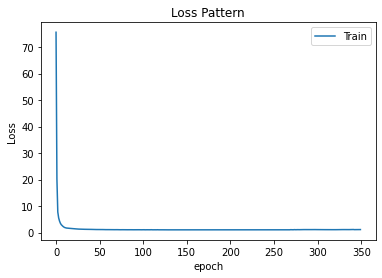

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold
# np.quantile(error_vector, anomaly_threshold)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 12.030961751937866
[False False False ...  True  True  True]


0.9318410386127449

In [15]:
print(len(X_test_VAE))

328130


## Metrics

In [16]:
sys.stdout = open("Results/ennio_doorbell.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate and anomaly threshold ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'